100%|███████████████████████████████████████████████████████████████████████| 101/101 [09:06<00:00,  5.41s/it]

1.0405489900982086


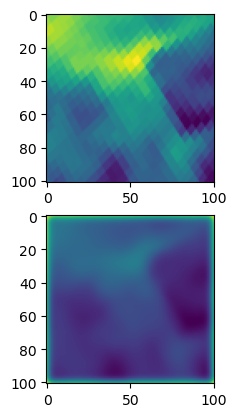

In [1]:
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import tqdm
from firesong.Firesong import firesong_simulation
#%matplotlib ipympl
sys.path.append('../LHAASO_PSF/PSFConv/') 
import Plot
import PSF

#------------------------参数设置----------------------------------
radius = 5 #图像半径
xsize = 500 #卷积前的图像尺寸，每像素对应尺度为 2*radius/xsize, 这个值应当设置得较小。
nfigure = 101 #生成多少张训练图像
ra_center = np.linspace(0,360,nfigure) #每张图像的中心坐标
dec_center = np.linspace(-90,90,nfigure)

binsize = 0.1  #单位是度，必须大于卷积前像素的尺度

NSIDE = 1024  #全天图的分辨率

#-------------------------程序主体----------------------------------

galabkg = np.load('Fermi-LAT_pi0_map.npy')
galabkg = hp.ud_grade(galabkg,NSIDE)

hp.mollview(np.log10(galabkg))
Plot.plotGala()
hp.graticule(dpar = 10,dmer=10)

ROI = []
ROI_BLUR = []

for i in tqdm.trange(nfigure):
    ra_c,dec_c = (ra_center[i],dec_center[i])

    #------真实坐标不重要---------
    x = np.linspace(-radius,radius,xsize)
    y = np.linspace(-radius,radius,xsize)

    #----------------按照中心坐标和半径选取天区-----------------------
    roi = Plot.selectreg(np.log10(galabkg),ra_c,dec_c,radius,NSIDE,xsize=xsize,plot = False)

    #------------对图像逐一卷积，如果卷积前分辨率很高，耗时会很长。--------------------
    #使用了scipy.signal.convolve2d来卷积
    psfconv= PSF.fitpsf(0,plot=False)
    roi_blur = psfconv(roi,x,y)

    #-----------------重新分bin---------------------
    roi_rebin,xx,yy  = PSF.bindata(roi,x,y,binsize)
    blur_rebin,xx,yy = PSF.bindata(roi_blur,x,y,binsize)
    
    ROI.append(roi_rebin)
    ROI_BLUR.append(blur_rebin)

a  =10
fig,ax= plt.subplots(2)
ax[0].imshow(ROI[a])
ax[1].imshow(ROI_BLUR[a])
print(ROI[a].sum()/ROI_BLUR[a].sum())

ORIG = np.array(ROI)
BLUR = np.array(ROI_BLUR)
np.save('../SimulatedData/original.npy',ORIG)
np.save('../SimulatedData/blurred.npy',BLUR)